# 先行研究モデル

## 必要なモジュールのインポート

In [310]:
%load_ext tensorboard
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## データセットの用意

### Google Colaboratory

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
train_path = "drive/My Drive/研究/swda_data/train/*"
test_path = "drive/My Drive/研究/swda_data/test/*"
val_path = "drive/My Drive/研究/swda_data/val/*"

### localhost

In [442]:
train_path = "./datasets/train/*"
test_path = "./datasets/test/*"
val_path = "./datasets/val/*"

In [443]:
train_lists = glob.glob(train_path)
test_lists = glob.glob(test_path)
val_lists = glob.glob(val_path)

### trainのデータセット

In [444]:
train_utter_user = []
train_utter = []
train_utter_label = []

In [445]:
train_dataset = []
for train_paths in train_lists:
  f = open(train_paths, "r", encoding='utf-8')
  t_list = []
  for row in f:
    t_list.append(row.strip())
  train_dataset.append(t_list)
  f.close()

In [446]:
for data in train_dataset:
  d_utter = []
  d_user = []
  d_label = []
  for da in data:
    for i, d in enumerate(da.split("|")):
      if i == 0:
        d_user.append(d)
      elif i == 1:
        d_utter.append(d)
      else:
        d = tag_set(d)
        d_label.append(d)
  
  train_utter_user.append(d_user)
  train_utter_label.append(d_label)
  train_utter.append(d_utter)
            
print("finish")

finish


In [447]:
n_trains = 0
for n in train_utter:
  for j in n:
    n_trains += 1
print(n_trains)

160876


### testのデータセット

In [448]:
test_utter_user = []
test_utter = []
test_utter_label = []

In [449]:
test_dataset = []
for test_paths in test_lists:
  f = open(test_paths, "r", encoding='utf-8')
  t_list = []
  for row in f:
    t_list.append(row.strip())
  test_dataset.append(t_list)
  f.close()

In [450]:
for data in test_dataset:
  d_utter = []
  d_user = []
  d_label = []
  for da in data:
    for i, d in enumerate(da.split("|")):
      if i == 0:
        d_user.append(d)
      elif i == 1:
        d_utter.append(d)
      else:
        d = tag_set(d)
        d_label.append(d)
  
  test_utter_user.append(d_user)
  test_utter_label.append(d_label)
  test_utter.append(d_utter)
            
print("finish")

finish


In [451]:
n_tests = 0
for n in test_utter:
  for j in n:
    n_tests += 1
print(n_tests)

20377


### valのデータセット

In [452]:
val_utter_user = []
val_utter = []
val_utter_label = []

In [453]:
val_dataset = []
for val_paths in val_lists:
  f = open(val_paths, "r", encoding='utf-8')
  t_list = []
  for row in f:
    t_list.append(row.strip())
  val_dataset.append(t_list)
  f.close()

In [454]:
for data in val_dataset:
  d_utter = []
  d_user = []
  d_label = []
  for da in data:
    for i, d in enumerate(da.split("|")):
      if i == 0:
        d_user.append(d)
      elif i == 1:
        d_utter.append(d)
      else:
        d = tag_set(d)
        d_label.append(d)
  
  val_utter_user.append(d_user)
  val_utter_label.append(d_label)
  val_utter.append(d_utter)
            
print("finish")

finish


In [455]:
n_vals = 0
for n in val_utter:
  for j in n:
    n_vals += 1
print(n_vals)

18487


### タグセット削減

In [456]:
def tag_set(tag):

    if tag == "sd" or tag =="sv":
        return "Statement"

    elif tag == "%" or tag == "t1" or tag == "t3":
        return "Uninterpretable"

    elif tag == "b" or tag == "br" or tag == "b^m" or tag == "^2" or tag == "bf" or tag == "bd" or tag == "ba" or tag == "bk":
        return "Understanding"

    elif tag == "aa" or tag == "aap_am" or tag == "ar" or tag == "^h" or tag == "ny" or tag == "nn" or tag == "na" or tag == "ng" or tag == "no" or tag == "arp_nd":
        return "Agreement"

    elif tag == "ad":
        return "Directive"

    elif tag == "fp" or tag == "fc":
        return "Greeting"

    elif tag == "qy" or tag == "qw" or tag == "qrr" or tag == "qy^d" or tag == "qw^d" or tag == "^g" or tag == "bh" or tag == "qh" or tag == "qo":
        return "Question"

    elif tag == "fa" or tag == "ft":
        return "Apology"

    else:
        return "Other"

### 発話処理

In [457]:
## ボキャブラリーリスト
vocabulary_set = set()
## トークナイザー
# tokenizer = tfds.deprecated.text.Tokenizer()
tokenizer = tfds.features.text.Tokenizer()
max_len = 0

# full_utter = [train_utter, test_utter, val_utter]

## 分かち書き
full_utter = [train_utter, test_utter, val_utter]
for utter in full_utter:
  for u in utter:
    for idx, text in enumerate(u):
      some_tokens = tokenizer.tokenize(text)
      vocabulary_set.update(some_tokens)
      if len(some_tokens) > max_len:
        max_len = len(some_tokens)

# encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set)
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)
## ボキャブラリーリスト作成
vocab_size = len(vocabulary_set)

In [458]:
# ID化
train = []
for i, dialogue in enumerate(train_utter):
  datasets = []
  for text in dialogue:
    some_ids = encoder.encode(text)
    datasets.append(np.pad(some_ids, [0, max_len - len(some_ids)], 'constant'))
  train.append(datasets)

In [459]:
# ID化
test = []
for i, dialogue in enumerate(test_utter):
  datasets = []
  for text in dialogue:
    some_ids = encoder.encode(text)
    datasets.append(np.pad(some_ids, [0, max_len - len(some_ids)], 'constant'))
  test.append(datasets)

In [460]:
# ID化
val = []
for i, dialogue in enumerate(val_utter):
  datasets = []
  for text in dialogue:
    some_ids = encoder.encode(text)
    datasets.append(np.pad(some_ids, [0, max_len - len(some_ids)], 'constant'))
  val.append(datasets)

### ラベル処理

In [461]:
act_tag_list = ["Statement", "Uninterpretable", "Understanding", "Agreement", "Directive", "Greeting", "Question", "Apology", "Other"]

In [462]:
full_act_label = [train_utter_label, test_utter_label, val_utter_label]
act = []
for acts in full_act_label:
  for ac in acts:
    for a in ac:
      act.append(a)

act_num = len(act_tag_list)

In [463]:
labels={}
for i,v in enumerate(act_tag_list):
    labels[v] = i

label_e = np.eye(act_num, k=1, dtype=np.int32)

label = {}
for i,v in enumerate(act_tag_list):
    label[v] = label_e[i]

In [464]:
# ID化
train_label = []
for i, act_lists in enumerate(train_utter_label):
  datasets = []
  for act in act_lists:
    datasets.append(label[act])
  train_label.append(datasets)

In [465]:
# ID化
test_label = []
for i, act_lists in enumerate(test_utter_label):
  datasets = []
  for act in act_lists:
    datasets.append(label[act])
  test_label.append(datasets)

In [466]:
# ID化
val_label = []
for i, act_lists in enumerate(val_utter_label):
  datasets = []
  for act in act_lists:
    datasets.append(label[act])
  val_label.append(datasets)

In [467]:
true_label = {}
for l, v in label.items():
    true_label[np.argmax(v)] = l

### ユーザ処理

In [468]:
u = ["A","B"]
e = np.eye(len(u), k=1, dtype=np.int32)
users_lists={}
for i,v in enumerate(u):
    users_lists[v] = e[i]

In [469]:
# ID化
train_user = []
for i, user_lists in enumerate(train_utter_user):
  datasets = []
  for user in user_lists:
    datasets.append(users_lists[user])
  train_user.append(datasets)

In [470]:
# ID化
test_user = []
for i, user_lists in enumerate(test_utter_user):
  datasets = []
  for user in user_lists:
    datasets.append(users_lists[user])
  test_user.append(datasets)

In [471]:
# ID化
val_user = []
for i, user_lists in enumerate(val_utter_user):
  datasets = []
  for user in user_lists:
    datasets.append(users_lists[user])
  val_user.append(datasets)

### データセットのTensorflow化

In [472]:
# 訓練対話データセット
train_dialogue_user = []
train_dialogue_utters = []
train_dialogue_act = []

# テスト対話データセット
test_dialogue_user = []
test_dialogue_utters = []
test_dialogue_act = []

# 検証対話データセット
val_dialogue_user = []
val_dialogue_utters = []
val_dialogue_act = []

In [473]:
## 対話数
dialog_size=6

#### 対話の訓練データ(発話予測)

In [474]:
## 訓練対話データ生成
for idx, utteraces in enumerate(train):
  
  for i in range(0, len(utteraces)-dialog_size):

    train_dialogue_utters.append([utteraces[x] for x in range(i, i+dialog_size)])
    train_dialogue_act.append([train_label[idx][x] for x in range(i, i+dialog_size)])
    train_dialogue_user.append([train_user[idx][x] for x in range(i, i+dialog_size)])

In [475]:
train_dialogues = tf.data.Dataset.from_tensor_slices((train_dialogue_user, train_dialogue_utters, train_dialogue_act))

#### 対話のテストデータ

In [476]:
## テスト対話データ生成
for idx, utteraces in enumerate(test):

  for i in range(0, len(utteraces)-dialog_size):
      
    test_dialogue_utters.append([utteraces[x] for x in range(i, i+dialog_size)])
    test_dialogue_act.append([test_label[idx][x] for x in range(i, i+dialog_size)])
    test_dialogue_user.append([test_user[idx][x] for x in range(i, i+dialog_size)])

In [477]:
test_dialogues = tf.data.Dataset.from_tensor_slices((test_dialogue_user, test_dialogue_utters, test_dialogue_act))

#### 対話の検証データ

In [478]:
## 訓練対話データ生成
for idx, utteraces in enumerate(val):
  
  for i in range(0, len(utteraces)-dialog_size):
    
    val_dialogue_utters.append([utteraces[x] for x in range(i, i+dialog_size)])
    val_dialogue_act.append([val_label[idx][x] for x in range(i, i+dialog_size)])
    val_dialogue_user.append([val_user[idx][x] for x in range(i, i+dialog_size)])

In [479]:
val_dialogues = tf.data.Dataset.from_tensor_slices((val_dialogue_user, val_dialogue_utters, val_dialogue_act))

### パディングサイズ

In [480]:
batch_size=64

In [481]:
utter_train_data = train_dialogues.padded_batch(batch_size, padded_shapes=([dialog_size, len(u)], [dialog_size, max_len], [dialog_size, act_num]))
utter_test_data = test_dialogues.padded_batch(batch_size, padded_shapes=([dialog_size, len(u)], [dialog_size, max_len],[dialog_size, act_num]))
utter_val_data = val_dialogues.padded_batch(batch_size, padded_shapes=([dialog_size, len(u)], [dialog_size, max_len],[dialog_size, act_num]))

In [482]:
sum_num = len(train_dialogue_utters) + len(test_dialogue_utters) + len(val_dialogue_utters)
print("train :" + str(len(train_dialogue_utters)/sum_num) + "%")
print("test :" + str(len(test_dialogue_utters)/sum_num) + "%")
print("val :" + str(len(val_dialogue_utters)/sum_num) + "%")

train :0.8052175717027125%
test :0.1022612935013744%
val :0.09252113479591308%


In [564]:
d,s,t = next(iter(utter_train_data)) 
print(d.shape)
print(s.shape)
print(t.shape)

(64, 6, 2)
(64, 6, 112)
(64, 6, 9)


In [566]:
for u in tf.unstack(s, axis=1):
    print(u.shape)

(64, 112)
(64, 112)
(64, 112)
(64, 112)
(64, 112)
(64, 112)


### グラフ化

In [483]:
count = 0
train_dialogue_act_list = {}
for l in true_label.values():
    for num in range(len(train_dialogue_act)):
        if true_label[np.argmax(train_dialogue_act[num][4])] == l:
            count += 1
    train_dialogue_act_list[l] = count
    count = 0

h_value = list(train_dialogue_act_list.values())
h_label = list(train_dialogue_act_list.keys())
x_list_act = [x for x in range(act_num)]

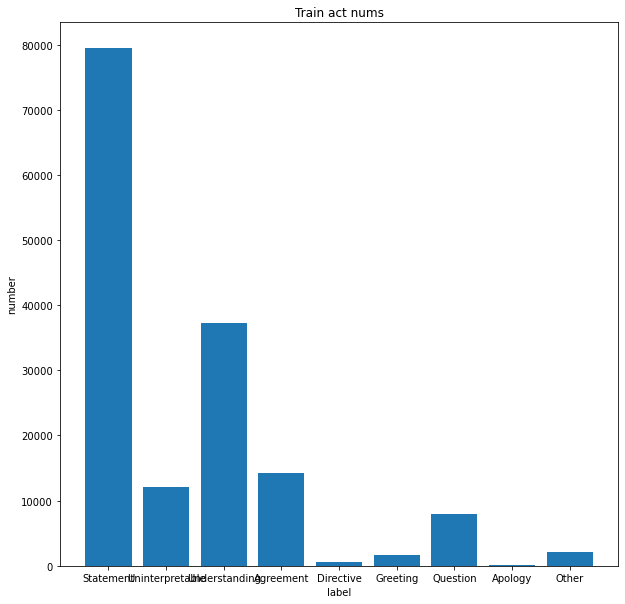

In [484]:
plt.figure(figsize=(10, 10))
plt.title("Train act nums")
plt.ylabel("number")
plt.xlabel("label")
plt.bar(x_list_act, h_value, tick_label=h_label, align="center")
plt.savefig("./logs/train_act_bar.png")

## 先行研究モデル(少し改善)

In [577]:
class DialogueActHiRNN(tf.keras.Model):
    
    def __init__(self, batch_size, units, act_units, output_size, embedding_word, embedding_act, vocab_size, user_num, rate=0.5):
        super(DialogueActHiRNN, self).__init__()
        
        ### 環境変数
        self.batch_size = batch_size
        self.units = units
        self.act_units = act_units
        self.output_size = output_size
        self.dialogue_count = 2
        
        ### 発話Embedding
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_word)
        
        ### 発話者Embedding
        self.user_embedding = tf.keras.layers.Embedding(user_num, self.units)
        
        ### 対話行為Embedding
        self.act_embedding = tf.keras.layers.Embedding(self.output_size, embedding_act)
        
        ### 発話RNN
        self.utterance_rnn = tf.keras.layers.GRU(self.units,
                                                return_sequences=True,
                                                return_state=False,
                                                recurrent_initializer='glorot_uniform')
        
        ### コンテキストRNN
        self.context_rnn = tf.keras.layers.GRU(self.units,
                                              return_sequences=True,
                                              return_state=True)

        ### 対話行為RNN
        self.dialogue_rnn = tf.keras.layers.GRU(self.act_units,
                                              return_sequences=True,
                                              return_state=True)

        ### プーリング層
        self.average_pooling = tf.keras.layers.GlobalAveragePooling1D()
        
        self.fc1 = tf.keras.layers.Dense(self.units, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.fc2 = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.fc3 = tf.keras.layers.Dense(self.output_size)
        
    def call(self, user_batch, utters_batch, act_batch):
        hidden_state = self._initialize_hidden_state(utters_batch.shape[0])
        
        for utters in tf.unstack(utters_batch, axis=1):
            
            ## 発話 Embedding
            emb = self.embedding(utters)
            
            ## 発話RNN
            utter_output = self.utterance_rnn(emb)

            ## 対話RNN
            context_output, context_state = self.context_rnn(utter_output, initial_state=hidden_state)
            hidden_state = context_state

        ## 対話行為タグの初期化
        hidden_dialogue_acts = self._dialogue_initialize_hidden_state(act_batch.shape[0])
        
        for acts in tf.unstack(act_batch, axis=1):

            ## 対話行為エンべディング
            dialogue_act_emb = self.act_embedding(acts)

            ## 対話行為RNN
            dialogue_act_output, state = self.dialogue_rnn(dialogue_act_emb, initial_state=hidden_dialogue_acts)
            hidden_dialogue_acts = state
        
        ## 発話と対話行為の連結
        concat_output = tf.concat([context_output, dialogue_act_output], 1)

        ## 次元の削減
        pooling_output = self.average_pooling(concat_output)
        
        ## NNの予測
        output = self.fc1(pooling_output)
#         output = self.dropout1(output)
#         output = self.fc2(output)
        output = self.dropout1(output)
        result = self.fc3(output)
        
        return result
            
    def _initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    def _dialogue_initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.act_units))

In [578]:
batch_size = 64
units = 512
act_units = 128*4
output_size = act_num
embedding_word = 300
embedding_act = 100
user_num = len(u)
dahrnn = DialogueActHiRNN(batch_size, units, act_units, output_size, embedding_word, embedding_act, vocab_size+1, user_num)

### 損失関数とオプティマイザー

In [488]:
## 訓練データのAccuracyとLose
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
## 訓練データのPrecisionとRecall
train_precision = tf.keras.metrics.Precision(name='train_precision')
train_recall = tf.keras.metrics.Recall(name='train_recall')

## 検証データのAccuracyとLose
val_losses = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

## 検証データのPrecisionとRecall
val_precision = tf.keras.metrics.Precision(name='val_precision')
val_recall = tf.keras.metrics.Recall(name='val_recall')

## オプティマイザー
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [138]:
## F値計算
def f1_score(precision, recall):
  return (2 * precision * recall) / (precision + recall)

## 先行研究モデル実行(発話予測)

In [318]:
import time
from tqdm import tqdm

In [203]:
EPOCHS = 20
## Accuracy
trains_list = []
val_trains_list = []
## Loss
losses_list = []
val_losses_list = []
## F値
train_f1_score_list = []
val_f1_score_list = []
min_loss = 0

In [489]:
checkpoint_path = "./save_weight/PreviousResearch_UtteraceActs.hdf5"

#### 訓練ステップ

In [513]:
@tf.function()

def train_step(user, utter, act_label):
  with tf.GradientTape() as tape:
    pred = dahrnn(user, utter, act_label[:, 0:-1])
    loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(
            act_label[:, -1], pred, from_logits=True
        )
    )
  grads = tape.gradient(loss, dahrnn.trainable_variables)
  optimizer.apply_gradients(zip(grads, dahrnn.trainable_variables))
  
  train_loss(loss)
  train_accuracy(act_label[:, -1], pred)

#### 検証ステップ

In [514]:
@tf.function()

def val_step(user, utter, act_label):
  val_pred = dahrnn(user, utter, act_label[:, 0:-1])
  loss = tf.reduce_mean(
      tf.keras.losses.categorical_crossentropy(
          act_label[:, -1], val_pred, from_logits=True
      )
  )

  val_losses(loss)
  val_accuracy(act_label[:, -1], val_pred)

#### 実行ステップ

In [515]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()

    val_losses.reset_states()
    val_accuracy.reset_states()
    
    for (utterace_users, dialogues, dialogue_act_label) in tqdm(utter_train_data):
        train_step(utterace_users, dialogues, dialogue_act_label)

    for (val_utterace_users, val_dialogues, val_dialogues_act_label) in tqdm(utter_val_data):
        val_step(val_utterace_users, val_dialogues, val_dialogues_act_label)

    if min_loss == 0:
      min_loss = val_losses.result()
      dahrnn.save_weights(checkpoint_path)
      print ('Saving checkpoint for epoch {}'.format(epoch + 1))
    else:
      if  min_loss > val_losses.result():
        min_loss = val_losses.result()
        dahrnn.save_weights(checkpoint_path)
        print ('Saving checkpoint for epoch {}'.format(epoch + 1))
      else:
        pass

    trains_list.append(train_accuracy.result())
    val_trains_list.append(val_accuracy.result())

    losses_list.append(train_loss.result())
    val_losses_list.append(val_losses.result())

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f} val_Loss {:.4f} val_Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_losses.result(),
                                                val_accuracy.result()))
print("finish")

21it [00:18,  1.15it/s]


KeyboardInterrupt: 

### 先行研究モデル 評価

In [ ]:
y_pred=[]
y_true=[]
for (x,y,z) in utter_test_data:

  for i in np.argmax(dahrnn(x, y, z[:, 0:-1]), axis=1):
    y_pred.append(true_label[i])
  for i in np.argmax(z[:, -1], axis=1):
    y_true.append(true_label[i])

In [ ]:
print(classification_report(y_true, y_pred))

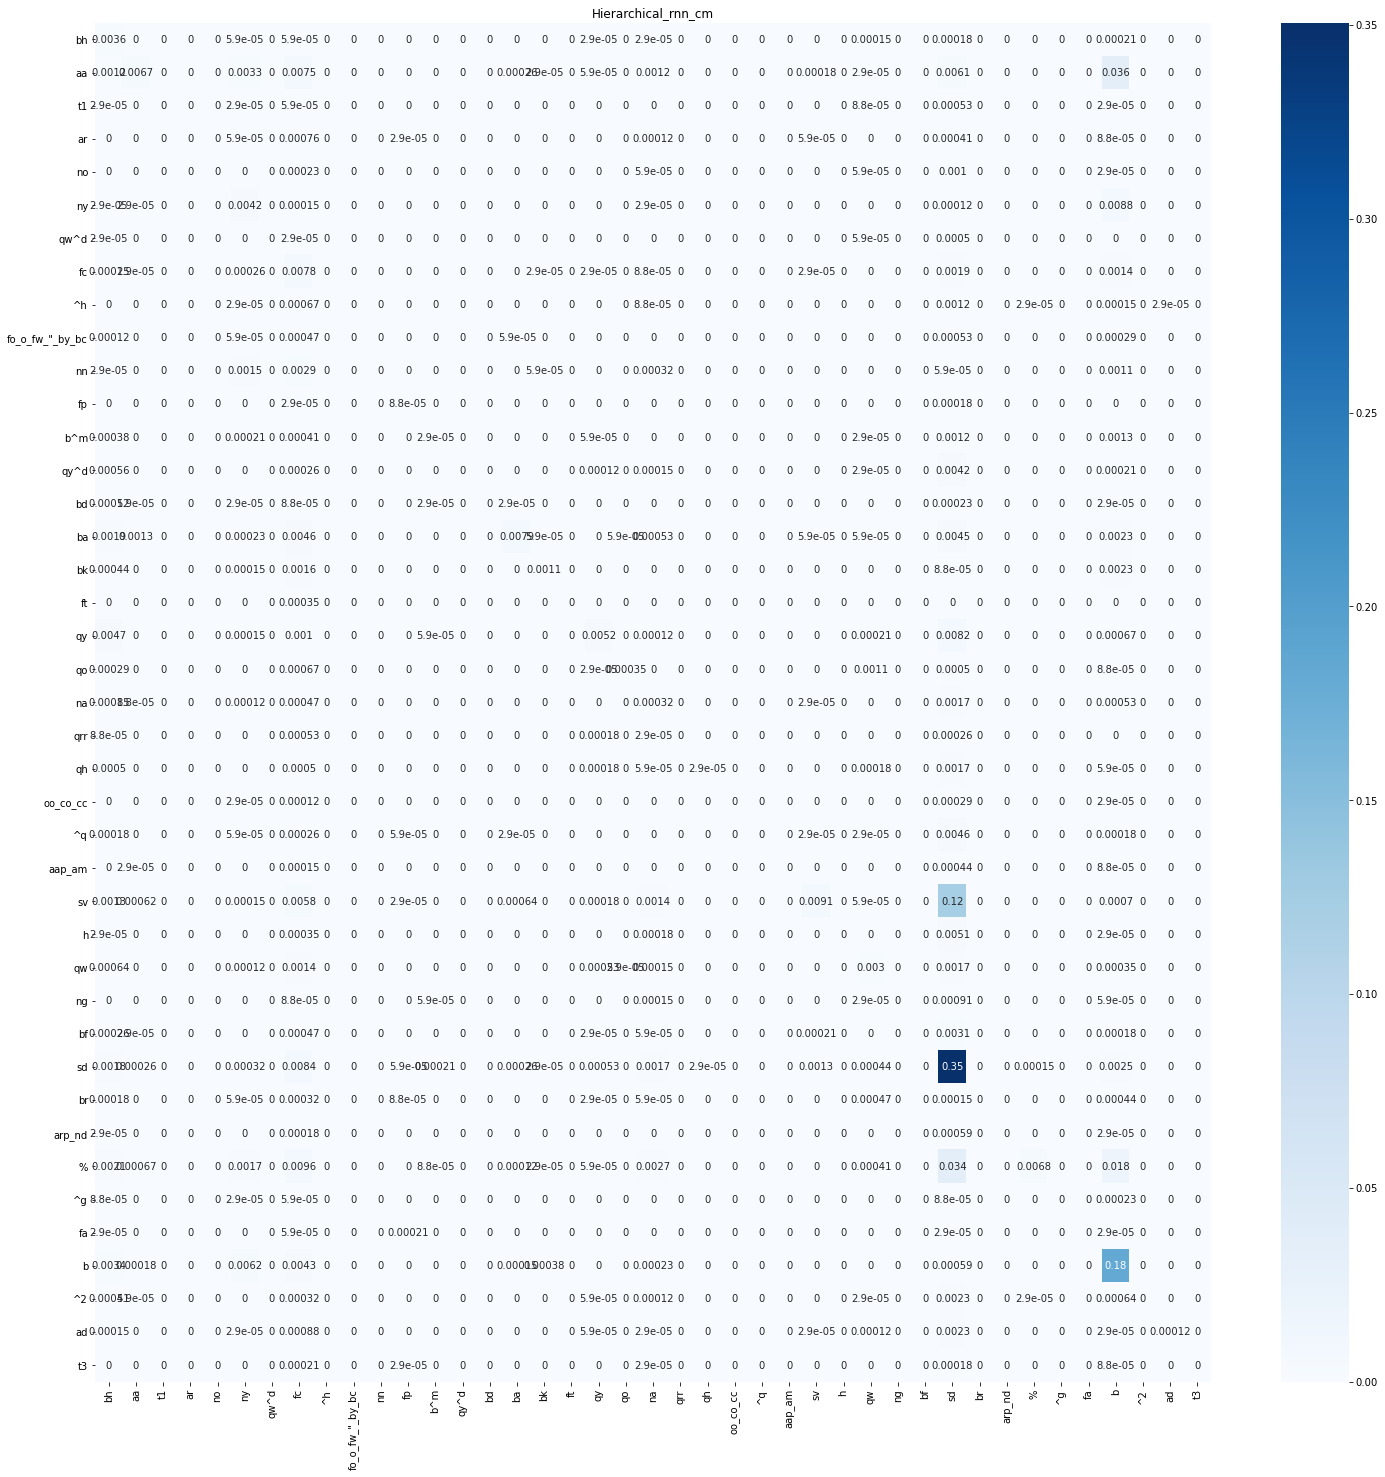

In [212]:
DialogueActHiRNN_cm = confusion_matrix(y_true, y_pred, act_labels, normalize='all')
df = pd.DataFrame(DialogueActHiRNN_cm, index=act_labels, columns=act_labels)
plt.figure(figsize=(25, 25))
plt.title("Hierarchical_rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
## colab
plt.savefig("./logs/cm/PreviousResearch_UtterAct_cm.png") 
## local
# plt.savefig("./Previous_research_rnn_cm.png") 

### 先行研究モデル 訓練状況

In [61]:
import matplotlib.pyplot as plt
epochs_list = [x for x in range(1, EPOCHS+1)]

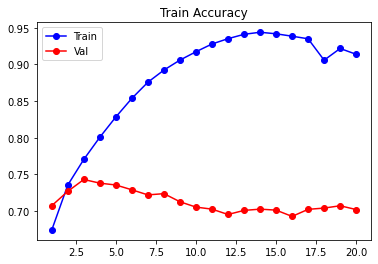

In [62]:
plt.plot(epochs_list,trains_list, marker='o', c='blue', label="Train")
plt.plot(epochs_list, val_trains_list,marker='o', c='red', label="Val")
plt.title("Train Accuracy")
plt.legend()
## colabであれば
plt.savefig("./logs/plot/PreviousResearch_UtterAct_plot.png") 
## local環境
# plt.savefig("./Previous_research_train_plot.png")

### lossの小さい重みを使った予測

In [228]:
dahrnn.load_weights(checkpoint_path)

In [229]:
y_pred=[]
y_true=[]
for (x,y,z) in utter_test_data:

  for i in np.argmax(dahrnn(x, y, z[:, 0:-1]), axis=1):
    y_pred.append(true_label [i])
  for i in np.argmax(z[:, -1], axis=1):
    y_true.append(true_label [i])

#### テストデータ F値

In [215]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

              %       0.70      0.77      0.74      2623
             ^2       0.00      0.00      0.00       134
             ^g       0.00      0.00      0.00        17
             ^h       0.37      0.47      0.42        76
             ^q       1.00      0.01      0.02       184
             aa       0.64      0.32      0.43      2116
         aap_am       0.00      0.00      0.00        24
             ad       0.53      0.23      0.32       129
             ar       0.00      0.00      0.00        52
         arp_nd       0.40      0.07      0.12        28
              b       0.74      0.97      0.84      6769
            b^m       0.23      0.07      0.11       123
             ba       0.73      0.63      0.68       800
             bd       0.00      0.00      0.00        21
             bf       0.11      0.01      0.01       147
             bh       0.54      0.52      0.53       147
             bk       0.50    

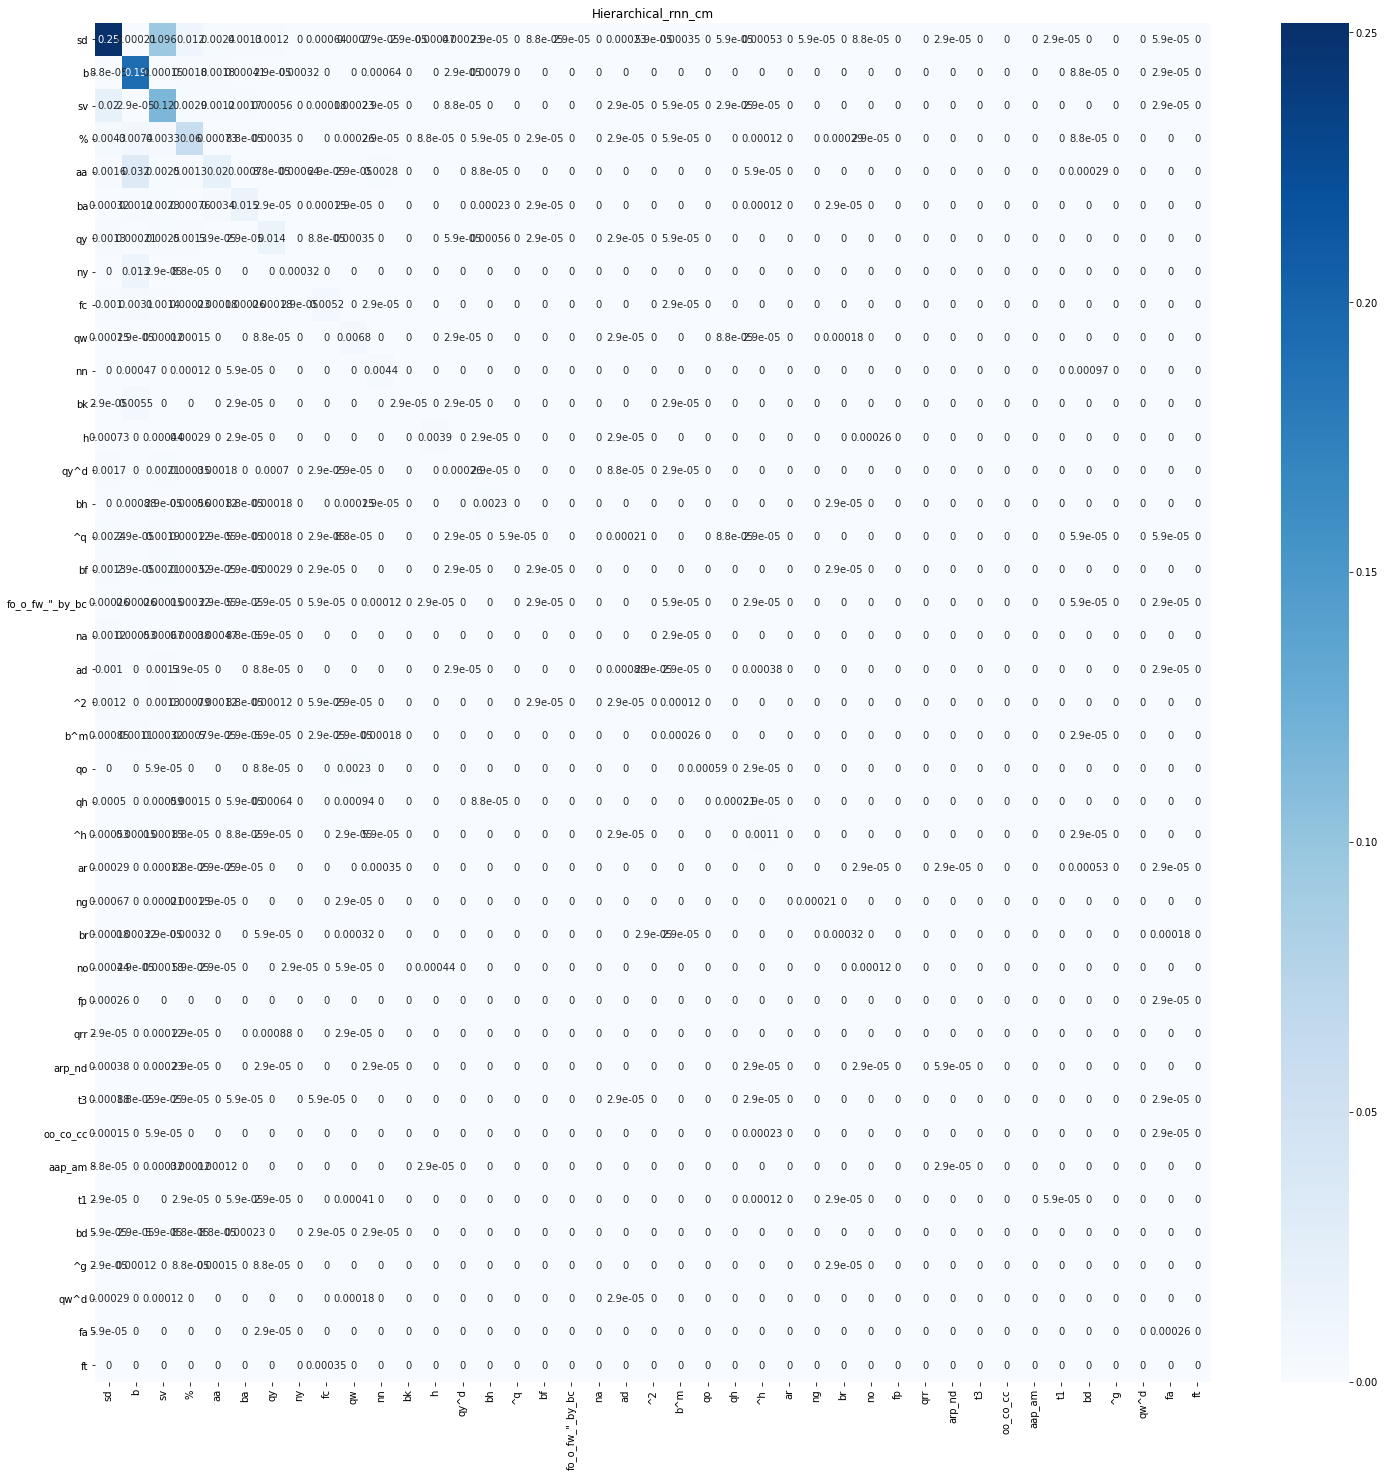

In [230]:
# act_labels = list(set(y_true + y_pred))

DialogueActHiRNN_cm = confusion_matrix(y_true, y_pred, act_labels, normalize='all')
df = pd.DataFrame(DialogueActHiRNN_cm, index=act_labels, columns=act_labels)
plt.figure(figsize=(25, 25))
plt.title("Hierarchical_rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
## colab
plt.savefig("./logs/cm/PreviousResearch_UtterAct_cm_v2.png") 

## 先行研究モデル実行(応答予測)

In [497]:
checkpoint_path = "./save_weight/PreviousResearch_ResponceActs.hdf5"

In [579]:
checkpoint_path = "./save_weight/PreviousResearch_ResponceActs_v2.hdf5"

In [580]:
@tf.function()

def train_step(user, utter, act_label):
  with tf.GradientTape() as tape:
    pred = dahrnn(user, utter[:, 0:-1], act_label[:, 0:-1])
    loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(
            act_label[:, -1], pred, from_logits=True
        )
    )
  grads = tape.gradient(loss, dahrnn.trainable_variables)
  optimizer.apply_gradients(zip(grads, dahrnn.trainable_variables))
  
  train_loss(loss)
  train_accuracy(act_label[:, -1], pred)

In [581]:
@tf.function()

def val_step(user, utter, act_label):
  val_pred = dahrnn(user, utter[:, 0:-1], act_label[:, 0:-1])
  loss = tf.reduce_mean(
      tf.keras.losses.categorical_crossentropy(
          act_label[:, -1], val_pred, from_logits=True
      )
  )

  val_losses(loss)
  val_accuracy(act_label[:, -1], val_pred)

In [582]:
EPOCHS = 20
## Accuracy
trains_list = []
val_trains_list = []
## Loss
losses_list = []
val_losses_list = []
## F値
train_f1_score_list = []
val_f1_score_list = []
min_loss = 0

### 実行

In [583]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()

    val_losses.reset_states()
    val_accuracy.reset_states()
    
    for (utterace_users, dialogues, dialogue_act_label) in tqdm(utter_train_data):
        train_step(utterace_users, dialogues, dialogue_act_label)
        
    for (val_utterace_users, val_dialogues, val_dialogues_act_label) in tqdm(utter_val_data):
        val_step(val_utterace_users, val_dialogues, val_dialogues_act_label)

    if min_loss == 0:
      min_loss = val_losses.result()
      dahrnn.save_weights(checkpoint_path)
      print ('Saving checkpoint for epoch {}'.format(epoch + 1))
    else:
      if  min_loss > val_losses.result():
        min_loss = val_losses.result()
        dahrnn.save_weights(checkpoint_path)
        print ('Saving checkpoint for epoch {}'.format(epoch + 1))
      else:
        pass

    trains_list.append(train_accuracy.result())
    val_trains_list.append(val_accuracy.result())

    losses_list.append(train_loss.result())
    val_losses_list.append(val_losses.result())

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f} val_Loss {:.4f} val_Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_losses.result(),
                                                val_accuracy.result()))
print("finish")

2426it [18:45,  2.16it/s]
279it [00:33,  8.39it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 1
Epoch 1 Loss 1.3400 Accuracy 0.5081 val_Loss 1.3021 val_Accuracy 0.5082


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 2
Epoch 2 Loss 1.2989 Accuracy 0.5134 val_Loss 1.2914 val_Accuracy 0.5061


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 3
Epoch 3 Loss 1.2885 Accuracy 0.5171 val_Loss 1.2742 val_Accuracy 0.5117


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 4
Epoch 4 Loss 1.2859 Accuracy 0.5196 val_Loss 1.2524 val_Accuracy 0.5207


2426it [18:38,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 5
Epoch 5 Loss 1.2851 Accuracy 0.5213 val_Loss 1.2357 val_Accuracy 0.5271


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 6
Epoch 6 Loss 1.2847 Accuracy 0.5244 val_Loss 1.2279 val_Accuracy 0.5334


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 7 Loss 1.2847 Accuracy 0.5286 val_Loss 1.2334 val_Accuracy 0.5304


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 8 Loss 1.2852 Accuracy 0.5313 val_Loss 1.2357 val_Accuracy 0.5295


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Epoch 9 Loss 1.2869 Accuracy 0.5347 val_Loss 1.2388 val_Accuracy 0.5278


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Epoch 10 Loss 1.2898 Accuracy 0.5372 val_Loss 1.2427 val_Accuracy 0.5290


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 11 Loss 1.2920 Accuracy 0.5404 val_Loss 1.2541 val_Accuracy 0.5297


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Epoch 12 Loss 1.2944 Accuracy 0.5425 val_Loss 1.2752 val_Accuracy 0.5301


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 13 Loss 1.2962 Accuracy 0.5460 val_Loss 1.2872 val_Accuracy 0.5299


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 14 Loss 1.2975 Accuracy 0.5475 val_Loss 1.2978 val_Accuracy 0.5302


2426it [18:37,  2.17it/s]
279it [00:31,  8.91it/s]
0it [00:00, ?it/s]

Epoch 15 Loss 1.2995 Accuracy 0.5493 val_Loss 1.3063 val_Accuracy 0.5304


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 16 Loss 1.3010 Accuracy 0.5514 val_Loss 1.3031 val_Accuracy 0.5303


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 17 Loss 1.3023 Accuracy 0.5529 val_Loss 1.3065 val_Accuracy 0.5295


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 18 Loss 1.3049 Accuracy 0.5528 val_Loss 1.3101 val_Accuracy 0.5261


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]
0it [00:00, ?it/s]

Epoch 19 Loss 1.3114 Accuracy 0.5522 val_Loss 1.3245 val_Accuracy 0.5274


2426it [18:37,  2.17it/s]
279it [00:31,  8.92it/s]

Epoch 20 Loss 1.3111 Accuracy 0.5545 val_Loss 1.3342 val_Accuracy 0.5204
finish


### 評価

In [584]:
y_pred=[]
y_true=[]
for (x,y,z) in utter_test_data:

  for i in np.argmax(dahrnn(x, y[:, 0:-1], z[:, 0:-1]), axis=1):
    y_pred.append(true_label[i])
  for i in np.argmax(z[:, -1], axis=1):
    y_true.append(true_label[i])

#### F値とAccuracy

In [585]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

      Agreement       0.32      0.14      0.20      1844
        Apology       0.00      0.00      0.00        17
      Directive       0.00      0.00      0.00        87
       Greeting       0.65      0.42      0.51       224
          Other       0.00      0.00      0.00       240
       Question       0.00      0.00      0.00       919
      Statement       0.55      0.84      0.67     10126
  Understanding       0.41      0.28      0.33      4788
Uninterpretable       0.00      0.00      0.00      1472

       accuracy                           0.52     19717
      macro avg       0.21      0.19      0.19     19717
   weighted avg       0.42      0.52      0.45     19717



#### 混同行列

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['Statement', 'Uninterpretable', 'Understanding', 'Agreement', 'Directive', 'Greeting', 'Question', 'Apology', 'Other'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


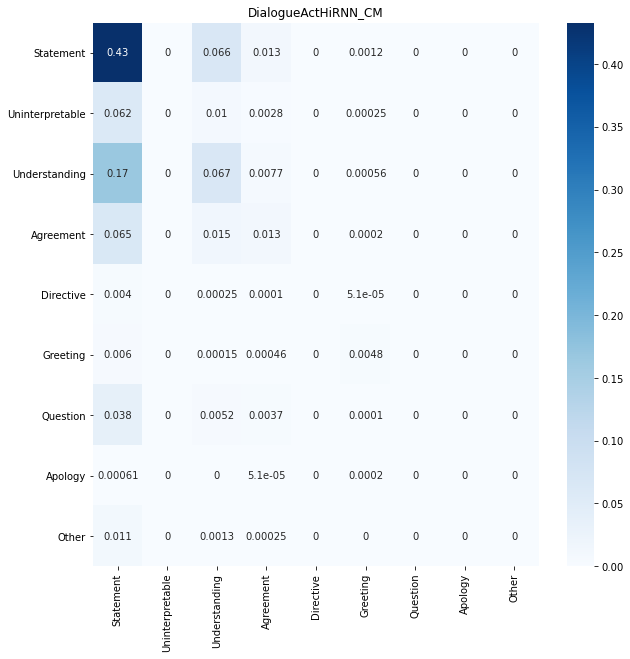

In [586]:
DialogueActHiRNN_cm = confusion_matrix(y_true, y_pred, act_tag_list, normalize='all')
df = pd.DataFrame(DialogueActHiRNN_cm, index=act_tag_list, columns=act_tag_list)
plt.figure(figsize=(10, 10))
plt.title("DialogueActHiRNN_CM")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
## colab
plt.savefig("./logs/cm/PreviousResearchReeponceAct_cm.png") 
## local
# plt.savefig("./Previous_research_rnn_cm.png") dropout1

### 検証Lossの小さい重みでの評価

In [587]:
dahrnn.load_weights(checkpoint_path)

In [588]:
y_pred=[]
y_true=[]
for (x,y,z) in utter_test_data:

  for i in np.argmax(dahrnn(x, y[:, 0:-1], z[:, 0:-1]), axis=1):
    y_pred.append(true_label[i])
  for i in np.argmax(z[:, -1], axis=1):
    y_true.append(true_label[i])

#### F値とAccuracy

In [589]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

      Agreement       0.35      0.13      0.19      1844
        Apology       0.00      0.00      0.00        17
      Directive       0.00      0.00      0.00        87
       Greeting       0.80      0.47      0.60       224
          Other       0.00      0.00      0.00       240
       Question       0.00      0.00      0.00       919
      Statement       0.55      0.86      0.67     10126
  Understanding       0.43      0.29      0.34      4788
Uninterpretable       0.00      0.00      0.00      1472

       accuracy                           0.53     19717
      macro avg       0.24      0.19      0.20     19717
   weighted avg       0.43      0.53      0.45     19717



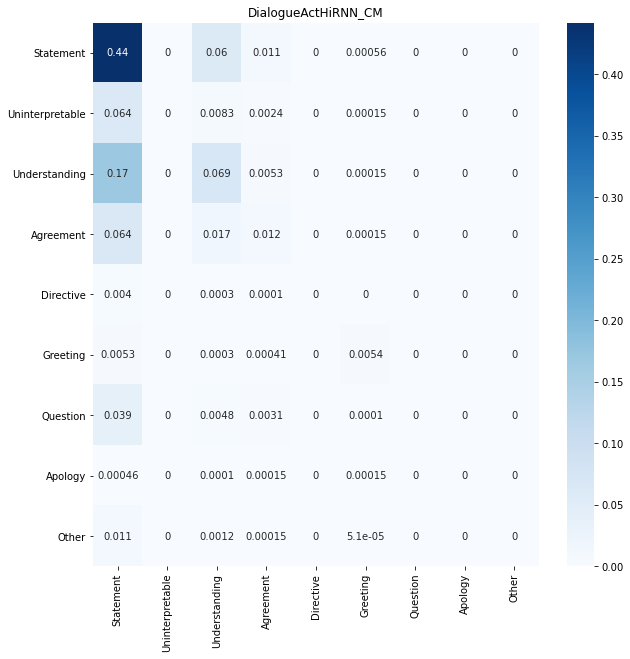

In [590]:
DialogueActHiRNN_cm = confusion_matrix(y_true, y_pred, act_tag_list, normalize='all')
df = pd.DataFrame(DialogueActHiRNN_cm, index=act_tag_list, columns=act_tag_list)
plt.figure(figsize=(10, 10))
plt.title("DialogueActHiRNN_CM")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
## colab
plt.savefig("./logs/cm/PreviousResearchReeponceAct_cm_v2.png") 

## 階層型モデルの実行(応答の対話行為推定)

In [591]:
EPOCHS = 20
## Accuracy
trains_list = []
val_trains_list = []
## Loss
losses_list = []
val_losses_list = []
## F値
train_f1_score_list = []
val_f1_score_list = []
min_loss = 0

In [592]:
checkpoint_path = "./save_weight/HierarchicalRNN_ResponceActs.hdf5"

#### 階層型モデル

In [593]:
class HierarchicalRNN(tf.keras.Model):
    def __init__(self, batch_size, units, output_size, embedding_word, vocab_size, rate=0.5):
        super(HierarchicalRNN, self).__init__()
        ### 環境変数
        self.batch_size = batch_size
        self.units = units
        self.output_size = output_size
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.user_embedding = tf.keras.layers.Embedding(2, self.units)
        
        self.utterance_rnn = tf.keras.layers.GRU(self.units,
                                                return_sequences=True,
                                                return_state=False,
                                                recurrent_initializer='glorot_uniform')
        self.context_rnn = tf.keras.layers.GRU(self.units,
                                              return_sequences=True,
                                              return_state=True)
        
        self.max_pooling = tf.keras.layers.GlobalMaxPooling1D()
        
        self.fc1 = tf.keras.layers.Dense(self.units, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.fc2 = tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.fc3 = tf.keras.layers.Dense(self.output_size)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)

    def call(self, user_batch, utters_batch):
        hidden_state = self._initialize_hidden_state(utters_batch.shape[0])
        
        for utters in tf.unstack(utters_batch, axis=1):
            
            ## 発話をエンべディング
            emb = self.embedding(utters)
            
            ## 発話RNN
            utter_output = self.utterance_rnn(emb)

            ## 対話RNN
            context_output, state = self.context_rnn(utter_output, initial_state=hidden_state)
            hidden_state = state
                
        ## 次元の削減
        pooling_output = self.max_pooling(context_output)
        
        
        ## NNの予測
        output = self.fc1(pooling_output)
        output = self.dropout1(output)
#         output = self.fc2(output)
#         output = self.dropout1(output)
        result = self.fc3(output)
        
        return result
            
    def _initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [594]:
hirnn = HierarchicalRNN(batch_size, units, output_size, embedding_word, vocab_size+1)

#### 階層型モデル実行

In [595]:
@tf.function()

def train_step(user, utter, act_label):
  with tf.GradientTape() as tape:
    pred = hirnn(user, utter[:, 0:-1])
    loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(
            act_label[:, -1], pred, from_logits=True
        )
    )
  grads = tape.gradient(loss, hirnn.trainable_variables)
  optimizer.apply_gradients(zip(grads, hirnn.trainable_variables))
  
  train_loss(loss)
  train_accuracy(act_label[:, -1], pred)
#   train_precision.update_state(dialogue_act_label[:, 1], pred)
#   train_recall.update_state(dialogue_act_label[:, 1], pred)

In [596]:
@tf.function()

def val_step(user, utter, act_label):
  val_pred = hirnn(user, utter[:, 0:-1])
  loss = tf.reduce_mean(
      tf.keras.losses.categorical_crossentropy(
          act_label[:, -1], val_pred, from_logits=True
      )
  )

  val_losses(loss)
  val_accuracy(act_label[:, -1], val_pred)
#   val_precision.update_state(dialogue_act_label[:, 1], val_pred)
#   val_recall.update_state(dialogue_act_label[:, 1], val_pred)

In [597]:
EPOCHS = 20
## Accuracy
trains_list = []
val_trains_list = []
## Loss
losses_list = []
val_losses_list = []
## F値
train_f1_score_list = []
val_f1_score_list = []
min_loss = 0

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()

    val_losses.reset_states()
    val_accuracy.reset_states()


    
    for (utterace_users, dialogues, dialogue_act_label) in tqdm(utter_train_data):
        train_step(utterace_users, dialogues, dialogue_act_label)
        
    for (val_utterace_users, val_dialogues, val_dialogues_act_label) in tqdm(utter_val_data):
        val_step(val_utterace_users, val_dialogues, val_dialogues_act_label)

    if min_loss == 0:
      min_loss = val_losses.result()
      hirnn.save_weights(checkpoint_path)
      print ('Saving checkpoint for epoch {}'.format(epoch + 1))
    else:
      if  min_loss > val_losses.result():
        min_loss = val_losses.result()
        hirnn.save_weights(checkpoint_path)
        print ('Saving checkpoint for epoch {}'.format(epoch + 1))
      else:
        pass

    trains_list.append(train_accuracy.result())
    val_trains_list.append(val_accuracy.result())

    losses_list.append(train_loss.result())
    val_losses_list.append(val_losses.result())

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f} val_Loss {:.4f} val_Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_losses.result(),
                                                val_accuracy.result()))
print("finish")

2426it [16:41,  2.42it/s]
279it [00:30,  9.14it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 1
Epoch 1 Loss 1.3111 Accuracy 0.5118 val_Loss 1.2938 val_Accuracy 0.5040


2426it [16:36,  2.44it/s]
279it [00:29,  9.56it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 2
Epoch 2 Loss 1.2976 Accuracy 0.5143 val_Loss 1.2889 val_Accuracy 0.5077


2426it [16:36,  2.44it/s]
279it [00:29,  9.56it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 3
Epoch 3 Loss 1.2866 Accuracy 0.5190 val_Loss 1.2768 val_Accuracy 0.5060


2426it [16:36,  2.44it/s]
279it [00:29,  9.57it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 4
Epoch 4 Loss 1.2786 Accuracy 0.5241 val_Loss 1.2628 val_Accuracy 0.5114


2426it [16:36,  2.44it/s]
279it [00:29,  9.56it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 5
Epoch 5 Loss 1.2735 Accuracy 0.5297 val_Loss 1.2476 val_Accuracy 0.5194


2426it [16:36,  2.43it/s]
279it [00:29,  9.57it/s]
0it [00:00, ?it/s]

Saving checkpoint for epoch 6
Epoch 6 Loss 1.2695 Accuracy 0.5341 val_Loss 1.2388 val_Accuracy 0.5226


2426it [16:36,  2.44it/s]
279it [00:29,  9.56it/s]
0it [00:00, ?it/s]

Epoch 7 Loss 1.2659 Accuracy 0.5396 val_Loss 1.2410 val_Accuracy 0.5217


2426it [16:36,  2.43it/s]
279it [00:29,  9.56it/s]
0it [00:00, ?it/s]

Epoch 8 Loss 1.2639 Accuracy 0.5435 val_Loss 1.2441 val_Accuracy 0.5219


2426it [16:35,  2.44it/s]
279it [00:29,  9.57it/s]
0it [00:00, ?it/s]

Epoch 9 Loss 1.2642 Accuracy 0.5440 val_Loss 1.2465 val_Accuracy 0.5275


1389it [09:30,  2.44it/s]

#### 階層型モデルの訓練状況

ValueError: x and y must have same first dimension, but have shapes (20,) and (15,)

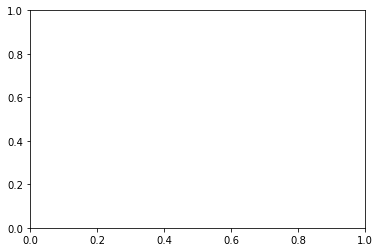

In [167]:
plt.plot(epochs_list,trains_list, marker='o', c='blue', label="Train")
plt.plot(epochs_list, val_trains_list,marker='o', c='red', label="Val")
plt.title("Train Accuracy")
plt.legend()
plt.savefig("./logs/plot/Hirnn_ResponseAct_plot.png") 

### 評価

In [ ]:
y_pred=[]
y_true=[]
for (x,y,z) in utter_test_data:

  for i in np.argmax(hirnn(x,y[:, 0:-1]), axis=1):
    y_pred.append(true_label[i])
  for i in np.argmax(z[:, -1], axis=1):
    y_true.append(true_label[i])

#### F値とAccuracy

In [ ]:
print(classification_report(y_true, y_pred))

#### 混同行列

In [ ]:
Hierarchical_rnn_cm = confusion_matrix(y_true, y_pred, act_tag_list, normalize='all')
df = pd.DataFrame(Hierarchical_rnn_cm, index=act_tag_list, columns=act_tag_list)
plt.figure(figsize=(10, 10))
plt.title("Hierarchical_rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
plt.savefig("./logs/cm/HiRnnResponseAct_cm.png") 

### 検証lossの低い値での確認

In [ ]:
hirnn.load_weights(checkpoint_path)

In [ ]:
y_pred=[]
y_true=[]
for (x,y,z) in utter_test_data:

  for i in np.argmax(hirnn(x,y[:, 0:-1]), axis=1):
    y_pred.append(true_label[i])
  for i in np.argmax(z[:, -1], axis=1):
    y_true.append(true_label[i])

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
Hierarchical_rnn_cm = confusion_matrix(y_true, y_pred, act_tag_list, normalize='all')
df = pd.DataFrame(Hierarchical_rnn_cm, index=act_tag_list, columns=act_tag_list)
plt.figure(figsize=(10, 10))
plt.title("Hierarchical_rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
plt.savefig("./logs/cm/HiRnnResponseAct_cm_v2.png") 

### File

In [438]:
import os
import shutil
from numpy.random import *

In [440]:
test_path = "./datasets/test/"
train_path = "./datasets/train/"
val_path = "./datasets/val/"
train_list = glob.glob(train_path + "*")
test_lists = glob.glob(test_path + "*")
val_lists = glob.glob(val_path + "*")

In [434]:
test_size = 90
test_data_lisr = choice(test_lists, test_size, replace=False)

In [436]:
len(test_data_lisr)

90

In [439]:
for i in test_data_lisr:
    shutil.move(i, train_path)

In [441]:
len(train_list), len(test_lists), len(val_lists)

(937, 110, 108)

# 提案モデル